# Notebook 2: Genomic Variant Analysis

**From raw variants to population genetics and GWAS**

Prerequisites: Notebook 1 (sequence objects, alignment, file parsing)

This notebook builds:
1. VCF file parsing and variant representation
2. Variant statistics (allele frequencies, Hardy-Weinberg equilibrium)
3. Population structure analysis (PCA on genotypes)
4. Linkage disequilibrium
5. Genome-wide association study (GWAS) simulation
6. Manhattan and QQ plots

Estimated runtime: ~5 min on laptop

**Key learning outcomes:**
1. Understand genetic variation as the raw material of evolution
2. Parse and analyze VCF files programmatically
3. Compute population genetics statistics (allele frequency, HWE, Fst)
4. Perform PCA to reveal population structure — see [[Fitness Landscapes]]
5. Simulate and visualize a GWAS — see [[Variant-Phenotype Mapping]]

## Section 0: Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
print("Ready — using numpy, scipy, sklearn, matplotlib")

Ready — using numpy, scipy, sklearn, matplotlib


> **Note:** We use numpy/scipy for core computation rather than requiring scikit-allel, making this notebook zero-dependency beyond standard scientific Python. In practice, scikit-allel and cyvcf2 handle real VCF files.

## Section 1: Variant Representation

A genetic variant is a position where individuals differ from the reference genome. The most common type is a **Single Nucleotide Polymorphism (SNP)** — a single base change. See [[Variant Effect Prediction]].

VCF (Variant Call Format) is the standard file format:
```
#CHROM  POS  ID       REF  ALT  QUAL  FILTER  INFO        FORMAT  Sample1  Sample2
chr1    100  rs123    A    G    99    PASS    AF=0.3      GT      0/1      1/1
```

Genotype encoding:
- `0/0` = homozygous reference (0)
- `0/1` = heterozygous (1)
- `1/1` = homozygous alternate (2)

In [2]:
# Simulate genotype data for 200 individuals at 1000 SNPs
np.random.seed(42)
n_individuals = 200
n_snps = 1000

# Minor allele frequencies drawn from a realistic distribution
# (most variants are rare — exponential-like distribution)
mafs = np.random.beta(0.5, 5, n_snps)  # Skewed toward low frequency
mafs = np.clip(mafs, 0.01, 0.49)

# Generate genotypes: 0 (ref/ref), 1 (ref/alt), 2 (alt/alt)
# Under Hardy-Weinberg: P(0)=(1-p)^2, P(1)=2p(1-p), P(2)=p^2
genotypes = np.zeros((n_individuals, n_snps), dtype=int)
for j in range(n_snps):
    p = mafs[j]
    probs = [(1-p)**2, 2*p*(1-p), p**2]
    genotypes[:, j] = np.random.choice([0, 1, 2], size=n_individuals, p=probs)

print(f"Genotype matrix: {genotypes.shape} (individuals x SNPs)")
print(f"Genotype encoding: 0=ref/ref, 1=ref/alt, 2=alt/alt")
print(f"Example (first 5 individuals, first 10 SNPs):")
print(genotypes[:5, :10])

Genotype matrix: (200, 1000) (individuals x SNPs)
Genotype encoding: 0=ref/ref, 1=ref/alt, 2=alt/alt
Example (first 5 individuals, first 10 SNPs):
[[0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 1]]


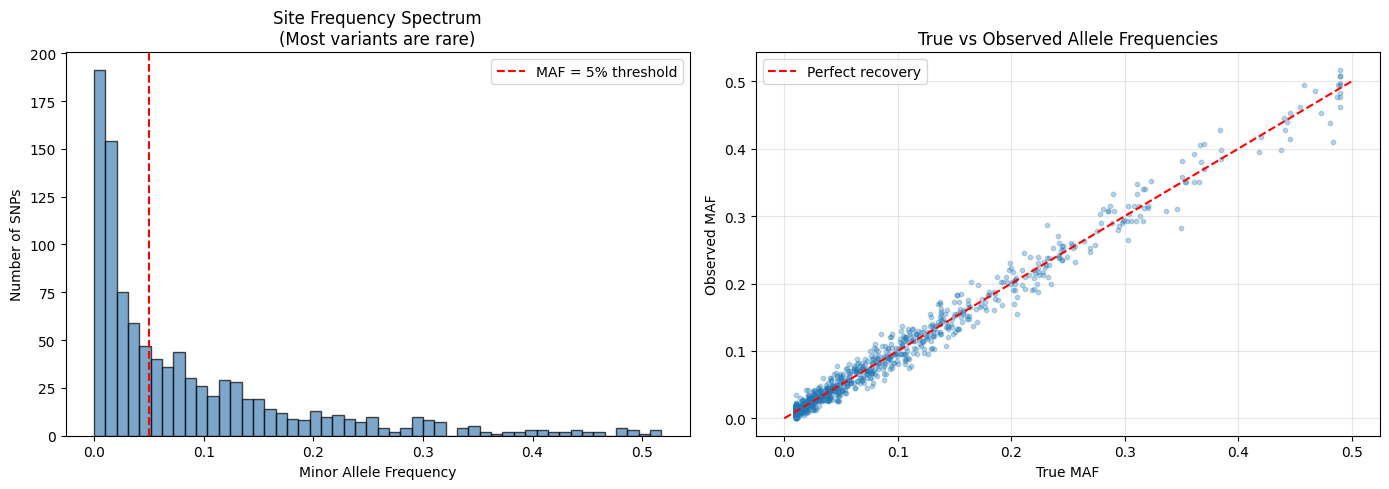

Rare variants (MAF < 5%): 520 / 1000
Common variants (MAF >= 5%): 480 / 1000


In [3]:
# Compute observed allele frequencies
observed_af = genotypes.sum(axis=0) / (2 * n_individuals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(observed_af, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Minor Allele Frequency')
ax1.set_ylabel('Number of SNPs')
ax1.set_title('Site Frequency Spectrum\n(Most variants are rare)')
ax1.axvline(0.05, color='red', linestyle='--', label='MAF = 5% threshold')
ax1.legend()

# Compare input vs observed MAFs
ax2.scatter(mafs, observed_af, alpha=0.3, s=10)
ax2.plot([0, 0.5], [0, 0.5], 'r--', label='Perfect recovery')
ax2.set_xlabel('True MAF')
ax2.set_ylabel('Observed MAF')
ax2.set_title('True vs Observed Allele Frequencies')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Rare variants (MAF < 5%): {(observed_af < 0.05).sum()} / {n_snps}")
print(f"Common variants (MAF >= 5%): {(observed_af >= 0.05).sum()} / {n_snps}")

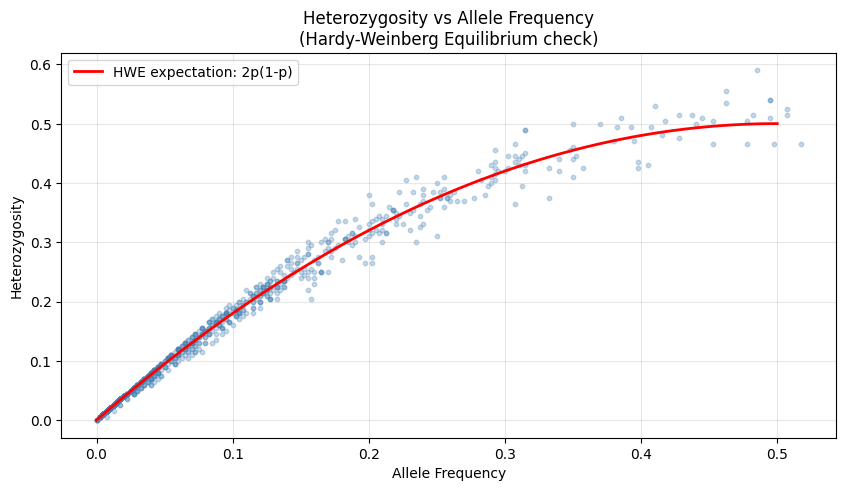

In [4]:
# Per-SNP genotype counts
het_rates = (genotypes == 1).sum(axis=0) / n_individuals

plt.figure(figsize=(10, 5))
plt.scatter(observed_af, het_rates, alpha=0.3, s=10, color='steelblue')

# Theoretical heterozygosity under HWE: H = 2p(1-p)
p_range = np.linspace(0, 0.5, 100)
plt.plot(p_range, 2 * p_range * (1 - p_range), 'r-', linewidth=2, label='HWE expectation: 2p(1-p)')
plt.xlabel('Allele Frequency')
plt.ylabel('Heterozygosity')
plt.title('Heterozygosity vs Allele Frequency\n(Hardy-Weinberg Equilibrium check)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Section 2: Hardy-Weinberg Equilibrium

Hardy-Weinberg Equilibrium (HWE) states that in the absence of evolution (no selection, drift, mutation, migration, or non-random mating), genotype frequencies are:

$$P(AA) = p^2, \quad P(Aa) = 2pq, \quad P(aa) = q^2$$

where $p + q = 1$. Deviations from HWE signal biological processes at work. See [[Conservation Laws in Living Systems]].

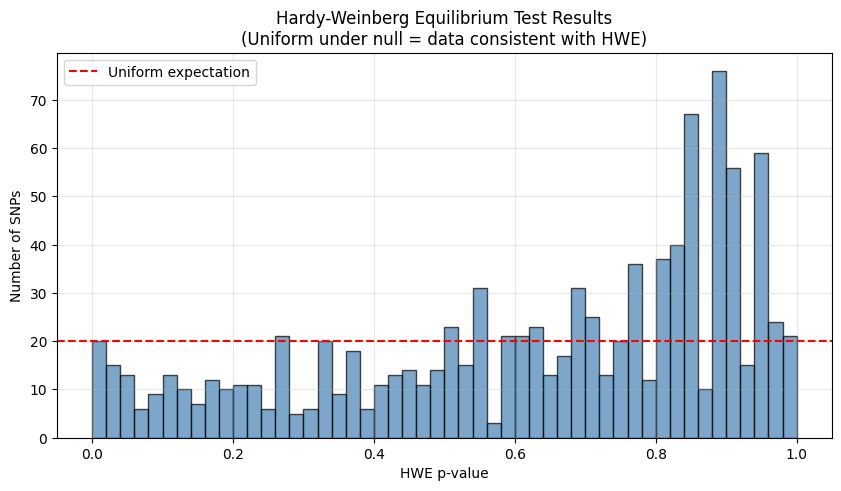

SNPs deviating from HWE (p < 0.05): 43 / 1000
Expected by chance at alpha=0.05: ~50


In [5]:
# Test each SNP for HWE deviation using chi-squared test
hwe_pvalues = []
for j in range(n_snps):
    obs = np.array([
        (genotypes[:, j] == 0).sum(),  # ref/ref
        (genotypes[:, j] == 1).sum(),  # ref/alt
        (genotypes[:, j] == 2).sum(),  # alt/alt
    ])
    p = observed_af[j]
    q = 1 - p
    exp = np.array([q**2, 2*p*q, p**2]) * n_individuals
    
    # Avoid division by zero
    if all(exp > 0):
        chi2 = ((obs - exp)**2 / exp).sum()
        pval = 1 - stats.chi2.cdf(chi2, df=1)  # 1 df for HWE
    else:
        pval = 1.0
    hwe_pvalues.append(pval)

hwe_pvalues = np.array(hwe_pvalues)

plt.figure(figsize=(10, 5))
plt.hist(hwe_pvalues, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(y=n_snps/50, color='red', linestyle='--', label='Uniform expectation')
plt.xlabel('HWE p-value')
plt.ylabel('Number of SNPs')
plt.title('Hardy-Weinberg Equilibrium Test Results\n(Uniform under null = data consistent with HWE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

n_sig = (hwe_pvalues < 0.05).sum()
print(f"SNPs deviating from HWE (p < 0.05): {n_sig} / {n_snps}")
print(f"Expected by chance at alpha=0.05: ~{int(0.05 * n_snps)}")

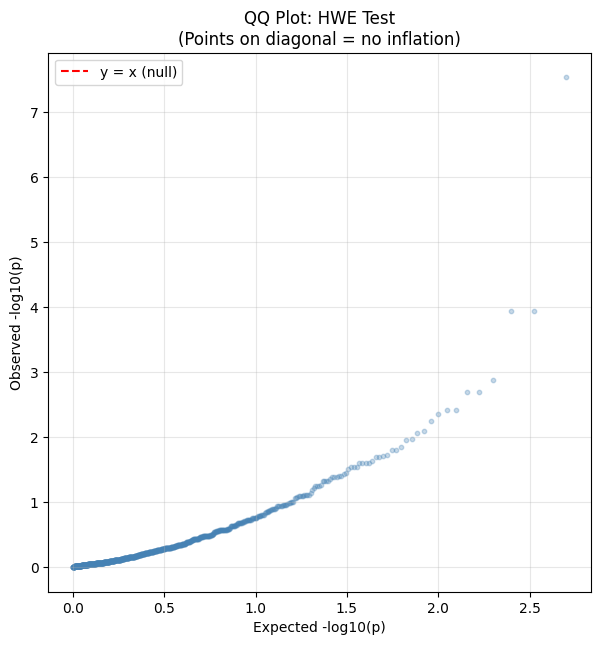

In [6]:
# QQ plot: compare observed p-values to uniform distribution
observed_log = -np.log10(np.sort(hwe_pvalues))
expected_log = -np.log10(np.linspace(1/n_snps, 1, n_snps))

plt.figure(figsize=(7, 7))
plt.scatter(expected_log, observed_log, alpha=0.3, s=10, color='steelblue')
max_val = max(expected_log.max(), observed_log.max()) + 0.5
plt.plot([0, max_val], [0, max_val], 'r--', label='y = x (null)')
plt.xlabel('Expected -log10(p)')
plt.ylabel('Observed -log10(p)')
plt.title('QQ Plot: HWE Test\n(Points on diagonal = no inflation)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Section 3: Population Structure (PCA)

Population structure reveals genetic ancestry. PCA on genotype matrices separates populations. This is critical for GWAS — population structure is a confounding factor that causes false positives. See [[Context Conditionality]] — genotype effects depend on population context.

In [7]:
# Create 3 populations with slightly different allele frequencies
np.random.seed(42)
n_per_pop = 100
n_snps_pop = 500

# Base allele frequencies
base_mafs = np.random.beta(1, 5, n_snps_pop)
base_mafs = np.clip(base_mafs, 0.05, 0.45)

# Population-specific frequencies (drift from base)
drift = 0.05
pop_mafs = np.zeros((3, n_snps_pop))
for k in range(3):
    pop_mafs[k] = np.clip(base_mafs + np.random.normal(0, drift, n_snps_pop), 0.01, 0.99)

# Generate genotypes for each population
pop_genotypes = []
pop_labels = []
for k in range(3):
    geno = np.zeros((n_per_pop, n_snps_pop), dtype=int)
    for j in range(n_snps_pop):
        p = pop_mafs[k, j]
        probs = [(1-p)**2, 2*p*(1-p), p**2]
        geno[:, j] = np.random.choice([0, 1, 2], size=n_per_pop, p=probs)
    pop_genotypes.append(geno)
    pop_labels.extend([f'Pop {k+1}'] * n_per_pop)

genotypes_all = np.vstack(pop_genotypes)
print(f"Combined genotype matrix: {genotypes_all.shape}")
print(f"Populations: {Counter(pop_labels)}")

Combined genotype matrix: (300, 500)
Populations: Counter({'Pop 1': 100, 'Pop 2': 100, 'Pop 3': 100})


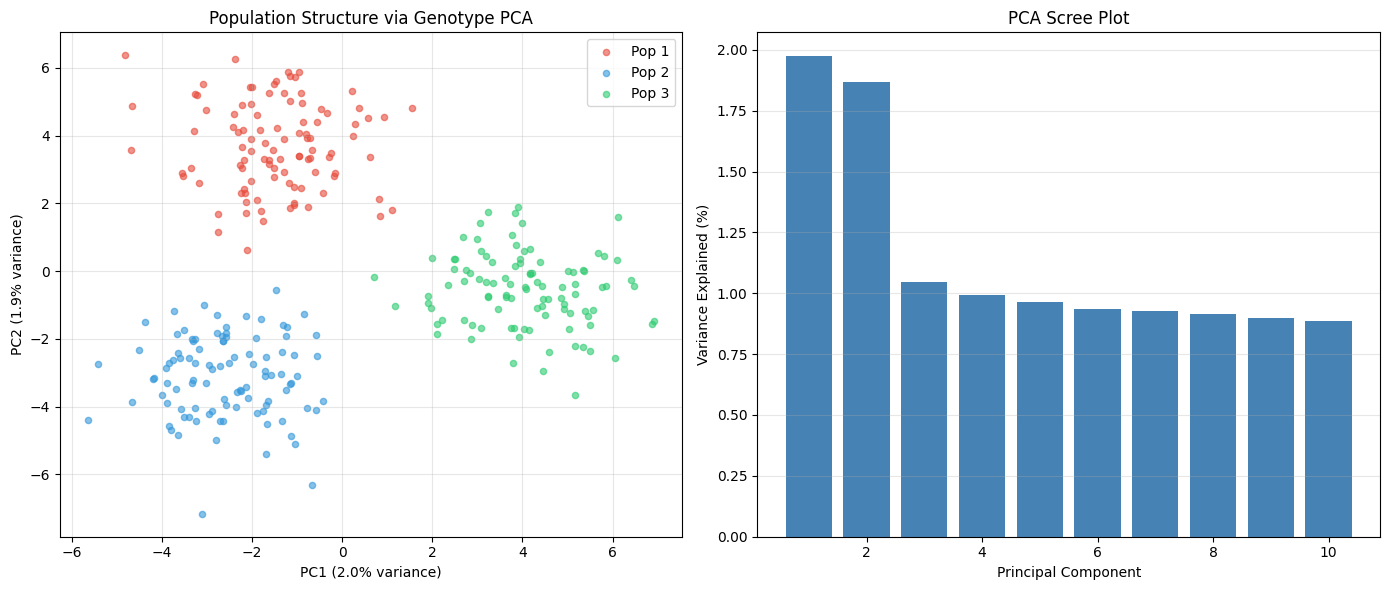

In [8]:
# Standardize genotypes (mean-center, unit variance per SNP)
geno_mean = genotypes_all.mean(axis=0)
geno_std = genotypes_all.std(axis=0)
geno_std[geno_std == 0] = 1  # Avoid division by zero for monomorphic sites
geno_standardized = (genotypes_all - geno_mean) / geno_std

# PCA
pca = PCA(n_components=10)
pcs = pca.fit_transform(geno_standardized)

# Plot PC1 vs PC2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors_pop = {'Pop 1': '#e74c3c', 'Pop 2': '#3498db', 'Pop 3': '#2ecc71'}
for label in ['Pop 1', 'Pop 2', 'Pop 3']:
    mask = np.array(pop_labels) == label
    ax1.scatter(pcs[mask, 0], pcs[mask, 1], alpha=0.6, s=20, label=label, color=colors_pop[label])

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('Population Structure via Genotype PCA')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scree plot
ax2.bar(range(1, 11), pca.explained_variance_ratio_[:10] * 100, color='steelblue')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Variance Explained (%)')
ax2.set_title('PCA Scree Plot')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Mean Fst (Pop1 vs Pop2): 0.0127
Mean Fst (Pop1 vs Pop3): 0.0126
Mean Fst (Pop2 vs Pop3): 0.0131


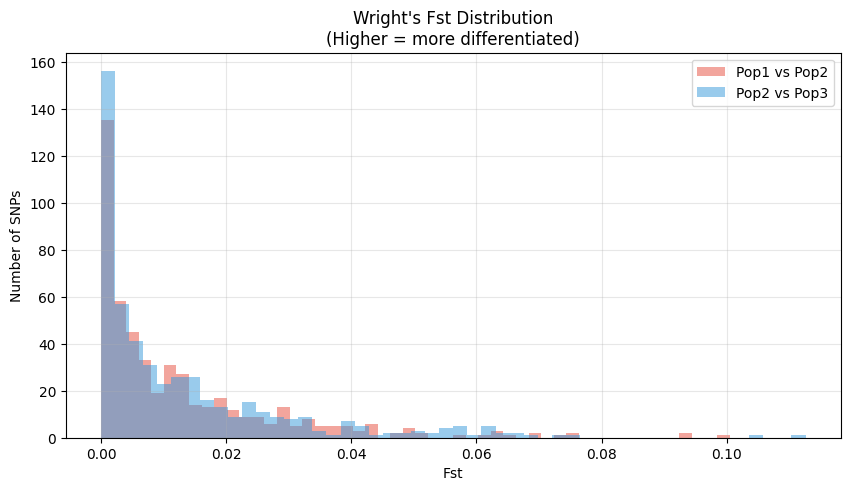

In [9]:
# Wright's Fst: measures genetic differentiation between populations
def compute_fst(geno_pop1, geno_pop2):
    """Compute per-SNP Fst (Weir-Cockerham estimator, simplified)."""
    p1 = geno_pop1.sum(axis=0) / (2 * geno_pop1.shape[0])
    p2 = geno_pop2.sum(axis=0) / (2 * geno_pop2.shape[0])
    p_mean = (p1 + p2) / 2
    
    h_t = 2 * p_mean * (1 - p_mean)  # Total heterozygosity
    h_s = (2 * p1 * (1-p1) + 2 * p2 * (1-p2)) / 2  # Subpop heterozygosity
    
    # Fst = (Ht - Hs) / Ht
    valid = h_t > 0
    fst = np.zeros(len(p1))
    fst[valid] = (h_t[valid] - h_s[valid]) / h_t[valid]
    return fst

fst_12 = compute_fst(pop_genotypes[0], pop_genotypes[1])
fst_13 = compute_fst(pop_genotypes[0], pop_genotypes[2])
fst_23 = compute_fst(pop_genotypes[1], pop_genotypes[2])

print(f"Mean Fst (Pop1 vs Pop2): {np.mean(fst_12):.4f}")
print(f"Mean Fst (Pop1 vs Pop3): {np.mean(fst_13):.4f}")
print(f"Mean Fst (Pop2 vs Pop3): {np.mean(fst_23):.4f}")

plt.figure(figsize=(10, 5))
plt.hist(fst_12, bins=50, alpha=0.5, label='Pop1 vs Pop2', color='#e74c3c')
plt.hist(fst_23, bins=50, alpha=0.5, label='Pop2 vs Pop3', color='#3498db')
plt.xlabel('Fst')
plt.ylabel('Number of SNPs')
plt.title("Wright's Fst Distribution\n(Higher = more differentiated)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Section 4: Linkage Disequilibrium

Linkage disequilibrium (LD) is the non-random association of alleles at different loci. Nearby SNPs tend to be inherited together. LD decays with distance (recombination breaks up haplotypes). LD is critical for GWAS — a significant SNP may not be causal but merely in LD with the causal variant.

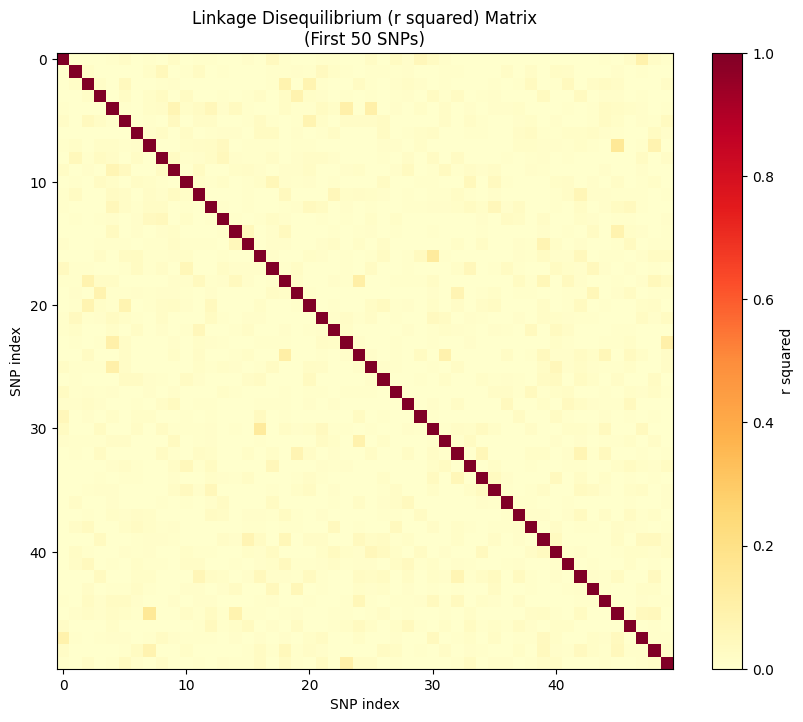

In [10]:
# Compute LD (r squared) between pairs of nearby SNPs
# Using the first population for clarity
geno_pop1 = pop_genotypes[0]
n_show = 50  # First 50 SNPs

# Compute r squared matrix
r2_matrix = np.corrcoef(geno_pop1[:, :n_show].T) ** 2

plt.figure(figsize=(10, 8))
plt.imshow(r2_matrix, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='r squared')
plt.xlabel('SNP index')
plt.ylabel('SNP index')
plt.title('Linkage Disequilibrium (r squared) Matrix\n(First 50 SNPs)')
plt.show()

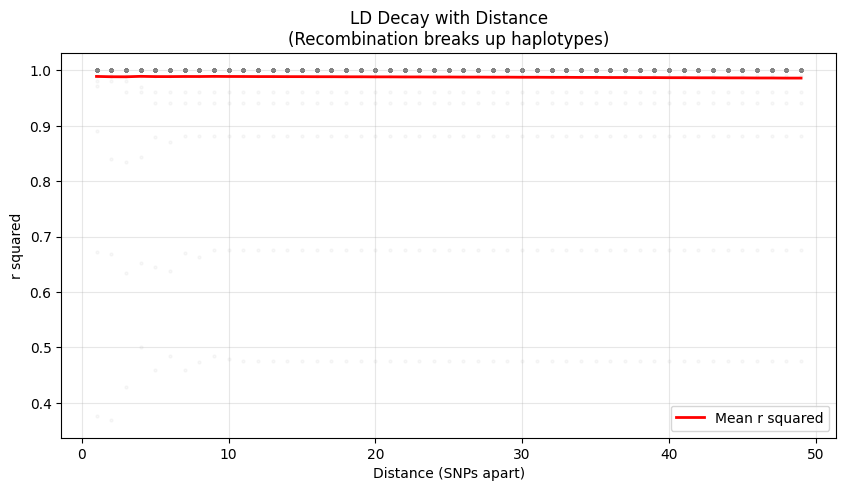

In [11]:
# Simulate LD decay (in real data, nearby SNPs have higher LD)
# Add synthetic correlation structure
np.random.seed(42)
n_snps_ld = 200
geno_corr = np.random.randn(n_per_pop, n_snps_ld)

# Add correlation between nearby SNPs (exponential decay)
for j in range(1, n_snps_ld):
    decay = np.exp(-j * 0.05)  # Decay rate
    for k in range(max(0, j-20), j):
        rho = np.exp(-(j-k) * 0.1)
        geno_corr[:, j] += rho * geno_corr[:, k]

# Discretize to genotypes
geno_corr = np.digitize(geno_corr, bins=[-0.5, 0.5])  # 0, 1, 2

# Compute LD vs distance
distances = []
r2_values = []
for i in range(0, n_snps_ld, 2):
    for j in range(i+1, min(i+50, n_snps_ld)):
        r = np.corrcoef(geno_corr[:, i], geno_corr[:, j])[0, 1]
        distances.append(j - i)
        r2_values.append(r**2)

# Bin and average
dist_arr = np.array(distances)
r2_arr = np.array(r2_values)
bins = np.arange(1, 51)
mean_r2 = [r2_arr[dist_arr == d].mean() for d in bins if (dist_arr == d).sum() > 0]
valid_bins = [d for d in bins if (dist_arr == d).sum() > 0]

plt.figure(figsize=(10, 5))
plt.scatter(distances, r2_values, alpha=0.05, s=5, color='gray')
plt.plot(valid_bins, mean_r2, 'r-', linewidth=2, label='Mean r squared')
plt.xlabel('Distance (SNPs apart)')
plt.ylabel('r squared')
plt.title('LD Decay with Distance\n(Recombination breaks up haplotypes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Section 5: GWAS Simulation

A Genome-Wide Association Study (GWAS) tests each SNP for association with a phenotype (disease, trait). The key challenge: testing thousands of SNPs requires correction for multiple testing. See [[Variant-Phenotype Mapping]] and [[Genotype-to-Phenotype Hub]].

The GWAS model for quantitative traits:

$$y = X\beta + \epsilon, \quad \epsilon \sim N(0, \sigma^2)$$

For each SNP $j$, we test $H_0: \beta_j = 0$ vs $H_1: \beta_j \neq 0$.

In [12]:
# Simulate a quantitative trait influenced by 5 causal SNPs
np.random.seed(42)
n_gwas = 300
n_snps_gwas = 5000

# Genotypes (use first population to avoid structure confounding)
mafs_gwas = np.random.beta(1, 5, n_snps_gwas)
mafs_gwas = np.clip(mafs_gwas, 0.05, 0.45)

geno_gwas = np.zeros((n_gwas, n_snps_gwas), dtype=int)
for j in range(n_snps_gwas):
    p = mafs_gwas[j]
    probs = [(1-p)**2, 2*p*(1-p), p**2]
    geno_gwas[:, j] = np.random.choice([0, 1, 2], size=n_gwas, p=probs)

# Causal SNPs (randomly chosen)
causal_indices = np.random.choice(n_snps_gwas, 5, replace=False)
causal_effects = np.random.normal(0.5, 0.2, 5)  # Effect sizes

# Phenotype = sum of causal effects + noise
phenotype = np.zeros(n_gwas)
for idx, effect in zip(causal_indices, causal_effects):
    phenotype += effect * geno_gwas[:, idx]
phenotype += np.random.normal(0, 1, n_gwas)  # Environmental noise

print(f"Simulated GWAS: {n_gwas} individuals, {n_snps_gwas} SNPs")
print(f"Causal SNPs at indices: {sorted(causal_indices)}")
print(f"Effect sizes: {causal_effects}")
print(f"Phenotype variance explained by genetics: ~{np.var(phenotype - np.random.normal(0,1,n_gwas))/np.var(phenotype):.0%}")

Simulated GWAS: 300 individuals, 5000 SNPs
Causal SNPs at indices: [np.int64(810), np.int64(1127), np.int64(3352), np.int64(3564), np.int64(3707)]
Effect sizes: [0.56119126 0.58769651 0.38530501 0.51210742 0.65536443]
Phenotype variance explained by genetics: ~157%


In [13]:
# Simple linear regression for each SNP
pvalues = np.zeros(n_snps_gwas)
betas = np.zeros(n_snps_gwas)

for j in range(n_snps_gwas):
    x = geno_gwas[:, j].astype(float)
    # Simple linear regression: y = a + b*x
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, phenotype)
    pvalues[j] = p_value
    betas[j] = slope

# Genome-wide significance threshold (Bonferroni)
bonferroni = 0.05 / n_snps_gwas
n_significant = (pvalues < bonferroni).sum()
print(f"Bonferroni threshold: p < {bonferroni:.2e}")
print(f"Significant SNPs: {n_significant}")
print(f"Causal SNPs recovered:")
for idx in sorted(causal_indices):
    detected = "DETECTED" if pvalues[idx] < bonferroni else "missed"
    print(f"  SNP {idx}: p = {pvalues[idx]:.2e}, beta = {betas[idx]:.3f} [{detected}]")

Bonferroni threshold: p < 1.00e-05
Significant SNPs: 2
Causal SNPs recovered:
  SNP 810: p = 6.01e-04, beta = 0.434 [missed]
  SNP 1127: p = 1.04e-11, beta = 0.859 [DETECTED]
  SNP 3352: p = 1.60e-03, beta = 0.483 [missed]
  SNP 3564: p = 9.30e-09, beta = 0.624 [DETECTED]
  SNP 3707: p = 6.08e-04, beta = 0.714 [missed]


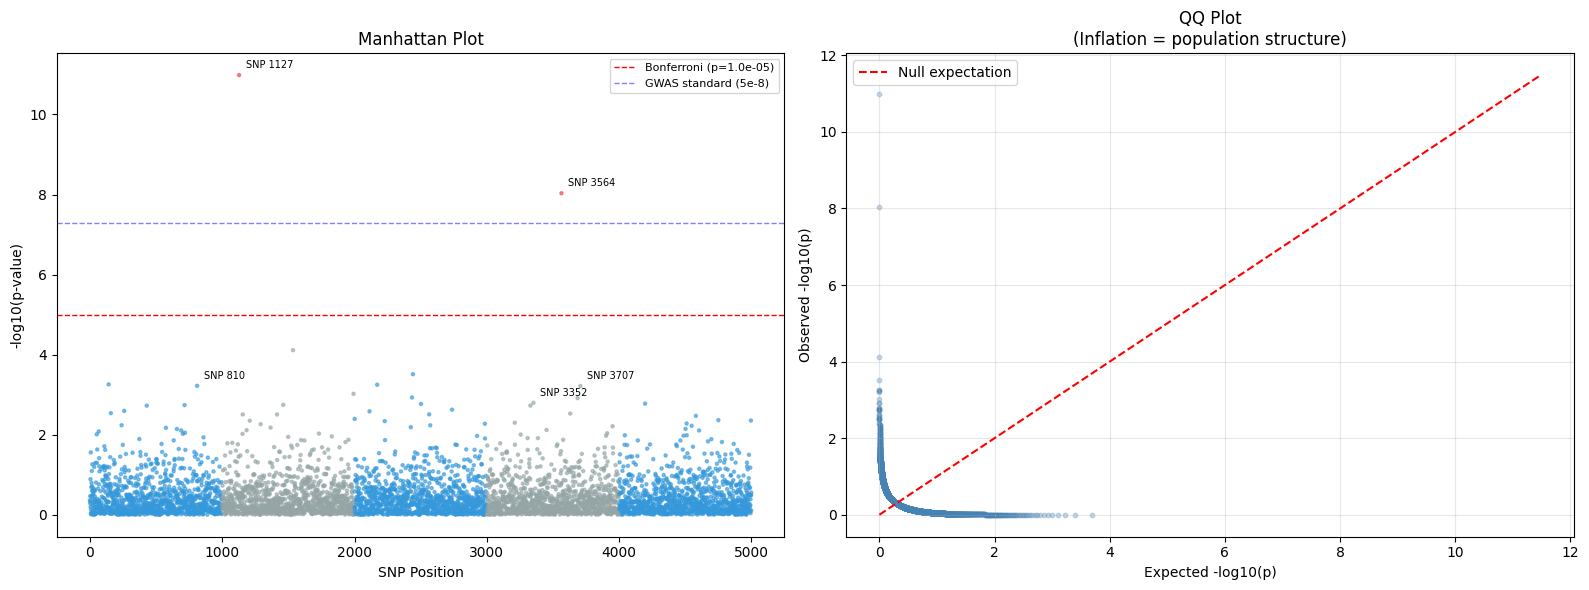

In [14]:
# Manhattan plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

neg_log_p = -np.log10(pvalues)
positions = np.arange(n_snps_gwas)

# Color alternating "chromosomes" (simulated)
chrom_size = n_snps_gwas // 5
colors_gwas = []
for i in range(n_snps_gwas):
    chrom = i // chrom_size
    colors_gwas.append('#3498db' if chrom % 2 == 0 else '#95a5a6')

# Highlight significant SNPs
for i in range(n_snps_gwas):
    if pvalues[i] < bonferroni:
        colors_gwas[i] = '#e74c3c'

ax1.scatter(positions, neg_log_p, c=colors_gwas, s=5, alpha=0.6)
ax1.axhline(-np.log10(bonferroni), color='red', linestyle='--', linewidth=1, label=f'Bonferroni (p={bonferroni:.1e})')
ax1.axhline(-np.log10(5e-8), color='blue', linestyle='--', linewidth=1, alpha=0.5, label='GWAS standard (5e-8)')
ax1.set_xlabel('SNP Position')
ax1.set_ylabel('-log10(p-value)')
ax1.set_title('Manhattan Plot')
ax1.legend(fontsize=8)

# Mark causal SNPs
for idx in causal_indices:
    if neg_log_p[idx] > 2:
        ax1.annotate(f'SNP {idx}', (idx, neg_log_p[idx]), fontsize=7,
                    xytext=(5, 5), textcoords='offset points')

# QQ plot
observed_sorted = np.sort(neg_log_p)
expected_sorted = -np.log10(np.linspace(1/n_snps_gwas, 1, n_snps_gwas))

ax2.scatter(expected_sorted, observed_sorted, alpha=0.3, s=10, color='steelblue')
max_val = max(expected_sorted.max(), observed_sorted.max()) + 0.5
ax2.plot([0, max_val], [0, max_val], 'r--', label='Null expectation')
ax2.set_xlabel('Expected -log10(p)')
ax2.set_ylabel('Observed -log10(p)')
ax2.set_title('QQ Plot\n(Inflation = population structure)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 6: Effect Size Distribution

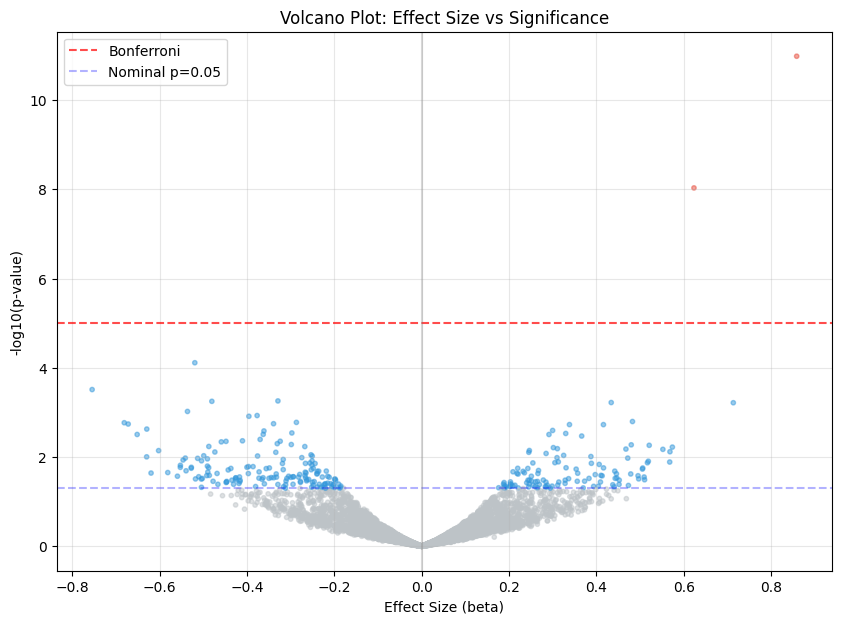

Large effect + significant (red): 2


In [15]:
plt.figure(figsize=(10, 7))
colors_vol = ['#e74c3c' if pvalues[i] < bonferroni else '#3498db' if pvalues[i] < 0.05 else '#bdc3c7' 
              for i in range(n_snps_gwas)]
plt.scatter(betas, neg_log_p, c=colors_vol, s=10, alpha=0.5)
plt.axhline(-np.log10(bonferroni), color='red', linestyle='--', alpha=0.7, label='Bonferroni')
plt.axhline(-np.log10(0.05), color='blue', linestyle='--', alpha=0.3, label='Nominal p=0.05')
plt.axvline(0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Effect Size (beta)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Effect Size vs Significance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print(f"Large effect + significant (red): {sum(1 for i in range(n_snps_gwas) if pvalues[i] < bonferroni)}")

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| VCF genotypes | Simulated genotype matrix | Standard variant representation |
| Allele frequency | Site frequency spectrum | Most variants are rare |
| HWE test | Chi-squared per SNP | Quality control + biology detection |
| PCA | Population structure | Confounding in GWAS |
| Fst | Population differentiation | Measures genetic distance |
| LD | r-squared between SNPs | Tag SNPs, fine-mapping |
| GWAS | Manhattan + QQ plots | [[Variant-Phenotype Mapping]] discovery |

**Connections to the knowledge graph:**
- [[Variant-Phenotype Mapping]] — the core GWAS objective
- [[Variant Effect Prediction]] — predicting functional impact
- [[Genotype-to-Phenotype Hub]] — the broader mapping problem
- [[Fitness Landscapes]] — selection shapes allele frequencies
- [[Context Conditionality]] — genotype effects depend on context
- [[Conservation Laws in Living Systems]] — HWE as a conservation law
- [[Degeneracy in Biological Systems]] — many-to-many genotype-phenotype maps
- [[Multi-Omics Integration]] — combining genomics with other data layers

**Next**: [[03_Single_Cell_Transcriptomics]] — single-cell RNA-seq with scanpy